In [65]:
import fairsearchcore as fsc
from fairsearchcore.models import FairScoreDoc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# One question analysis

In [66]:
df_for_fair = pd.read_csv("df_for_fair_74681417.csv")
df_for_fair.head()

,u_id,pscore,developed_country
0,100297,2.263848,1.0
1,3874623,2.024328,1.0
2,5923139,1.902712,1.0
3,7574575,1.897878,0.0
4,325565,1.845899,1.0


In [67]:
k = 100  # number of topK elements returned (value should be between 10 and 400)
p = 0.6398  # 1−0,3602, proportion of protected candidates in the topK elements (value should be between 0.02 and 0.98)
alpha = 0.05  # significance level (value should be between 0.01 and 0.15)

# create the Fair object
fair = fsc.Fair(k, p, alpha)

In [68]:
recom_ranking = [
    FairScoreDoc(int(u_id), pscore, bool(1 - dev_country))
    for _, (u_id, pscore, dev_country) in df_for_fair.iterrows()
]
fair.is_fair(recom_ranking[:k])

False

In [69]:
re_ranked = fair.re_rank(recom_ranking)
fair.is_fair(re_ranked)

True

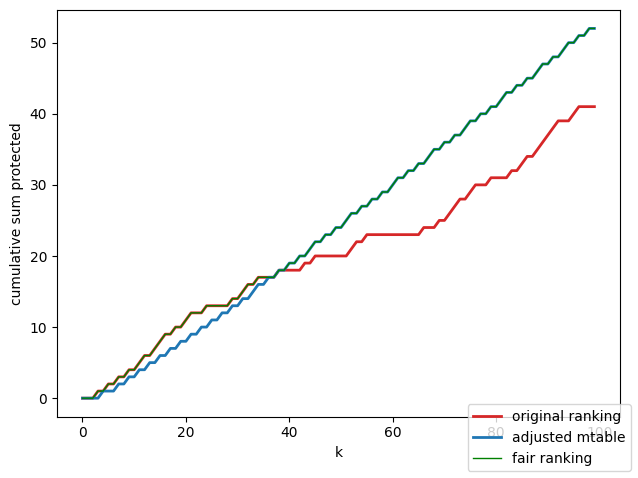

In [72]:
fig, ax1 = plt.subplots()

color = "tab:red"
ax1.set_xlabel("k")
ax1.set_ylabel("cumulative sum protected")
ax1.plot(
    range(k),
    (1 - df_for_fair[:k]["developed_country"]).cumsum(),
    color=color,
    label="original ranking",
    linewidth=2,
)
ax1.plot(range(k), fair.create_adjusted_mtable(), label="adjusted mtable", linewidth=2)
ax1.plot(
    range(k),
    np.cumsum([int(re_r.is_protected) for re_r in re_ranked]),
    color="green",
    label="fair ranking",
    linewidth=1,
)
fig.legend(loc="lower right")

fig.tight_layout()
plt.show()

grosor rojo cambiar

 - sincornizar repos
 - cuantos cambios se hacen para hacer un ranking justo
    - como cuento los cambios? levenshtein?

para el n 1, buscar si esta movido

/home/dml/.pyenv/versions/3.7.14/envs/so_q_recom_fair/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dml/.pyenv/versions/3.7.14/envs/so_q_recom_fair/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


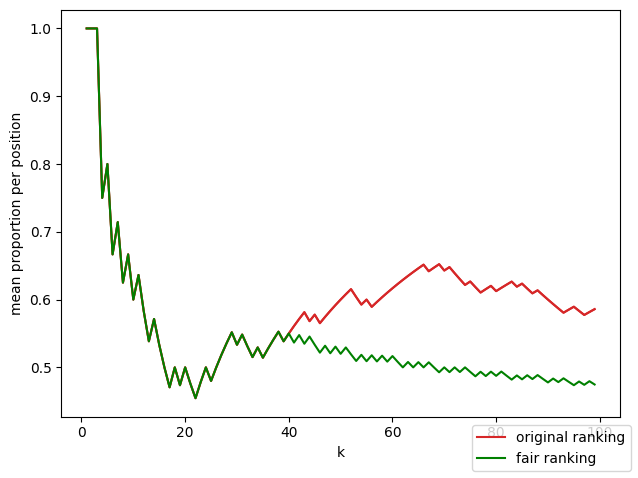

In [71]:
fig, ax1 = plt.subplots()


mean_proportion = []
mean_proportion_fair = []
# process pool
for top_k in range(k):
    mean_proportion.append(df_for_fair.head(top_k)["developed_country"].mean())
    mean_proportion_fair.append(
        np.mean([1 - int(re_r.is_protected) for re_r in re_ranked[:top_k]])
    )

color = "tab:red"
ax1.set_xlabel("k")
ax1.set_ylabel("mean proportion per position")
ax1.plot(range(k), mean_proportion, color=color)
ax1.plot(range(k), mean_proportion, color=color, label="original ranking")
ax1.plot(range(k), mean_proportion_fair, color="green", label="fair ranking")
fig.legend(loc="lower right")

fig.tight_layout()
plt.show()

# All questions

In [9]:
df_for_fair_complete = pd.read_csv("df_for_fair_complete.csv")
df_for_fair_complete.head()

,q_id,u_id,pscore,developed_country
0,70547027,100297,2.340971,1.0
1,70547027,7574575,2.266549,0.0
2,70547027,11923558,2.071728,0.0
3,70547027,1624921,2.033441,1.0
4,70547027,325565,1.930067,1.0


In [10]:
len(df_for_fair_complete["q_id"].unique())

3973

In [11]:
questions_rankings = defaultdict(list)

for _, (q_id, u_id, pscore, dev_country) in df_for_fair_complete.iterrows():
    questions_rankings[q_id].append(
        FairScoreDoc(int(u_id), pscore, bool(1 - dev_country))
    )

In [12]:
questions_rankings_is_fair = {
    q_id: fair.is_fair(ranking[:k]) for q_id, ranking in questions_rankings.items()
}

In [13]:
questions_rankings_is_fair[70547027]

False

In [14]:
questions_rankings_fair = dict()
questions_rankings_fair_is_fair = dict()

for q_id, ranking in questions_rankings.items():
    re_ranked = fair.re_rank(ranking)
    questions_rankings_fair[q_id] = re_ranked
    questions_rankings_fair_is_fair[q_id] = fair.is_fair(re_ranked)

In [15]:
questions_rankings_fair_is_fair[70547027]

True

In [16]:
sum(questions_rankings_is_fair.values()), sum(questions_rankings_fair_is_fair.values())

(2, 3973)

In [17]:
list(range(5, 100, 5))

[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]

In [18]:
top_k = list(range(5, 100, 5))

mean_proportion = []
mean_proportion_fair = []
# process pool
for k in top_k:
    mean_proportion.append(
        df_for_fair_complete.groupby("q_id")[["developed_country", "q_id"]]
        .apply(lambda x: x.head(k)["developed_country"].mean())
        .mean()
    )

    aux_prop = []
    for ranking in questions_rankings_fair.values():
        aux_prop.append(np.mean([1 - int(re_r.is_protected) for re_r in ranking[:k]]))
    mean_proportion_fair.append(np.mean(aux_prop))

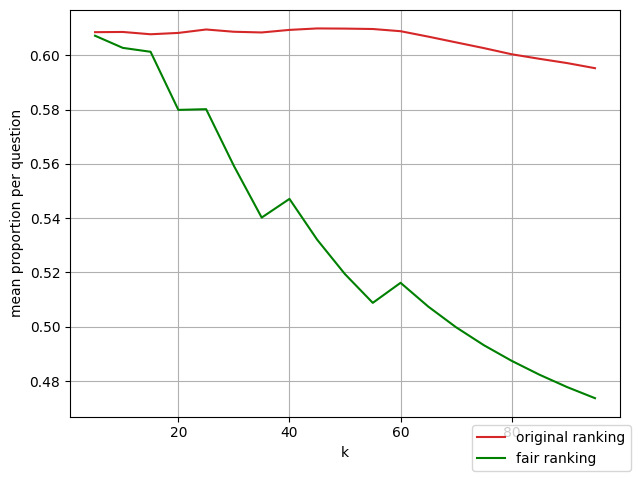

In [19]:
fig, ax1 = plt.subplots()

color = "tab:red"
ax1.set_xlabel("k")
ax1.set_ylabel("mean proportion per question")
ax1.plot(top_k, mean_proportion, color=color, label="original ranking")
ax1.plot(top_k, mean_proportion_fair, color="green", label="fair ranking")
fig.legend(loc="lower right")

fig.tight_layout()
plt.grid()
plt.show()

average ratio of non protected candidates

In [20]:
df_for_fair_complete["pos"] = (
    df_for_fair_complete[["q_id", "u_id"]].groupby("q_id").cumcount() + 1
)
df_for_fair_complete.head()

,q_id,u_id,pscore,developed_country,pos
0,70547027,100297,2.340971,1.0,1
1,70547027,7574575,2.266549,0.0,2
2,70547027,11923558,2.071728,0.0,3
3,70547027,1624921,2.033441,1.0,4
4,70547027,325565,1.930067,1.0,5


In [21]:
dev_country_per_pos = [0] * 350

for _, candidates in questions_rankings_fair.items():
    for pos, candidate in enumerate(candidates):
        dev_country_per_pos[pos] += 1 - int(candidate.is_protected)

In [22]:
dev_country_per_pos[:5]

[3587, 1961, 2110, 2142, 2263]

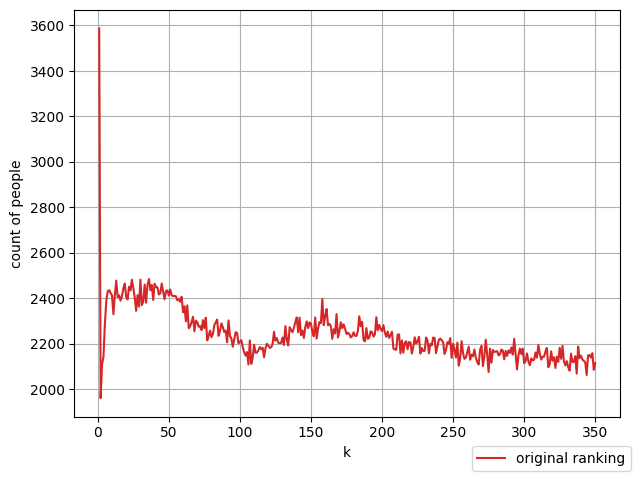

In [23]:
fig, ax1 = plt.subplots()

color = "tab:red"
ax1.set_xlabel("k")
ax1.set_ylabel("count of people")
ax1.plot(
    list(range(1, 351)),
    df_for_fair_complete[["developed_country", "pos"]]
    .groupby("pos")
    .sum()
    .values.flatten(),
    color=color,
    label="original ranking",
)
fig.legend(loc="lower right")

fig.tight_layout()
plt.grid()
plt.show()

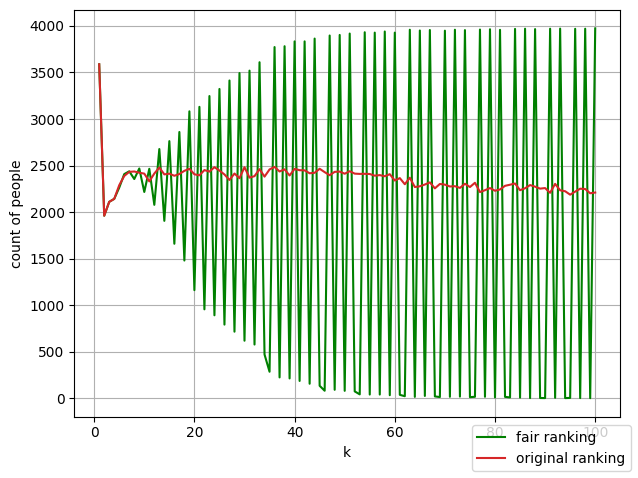

In [24]:
fig, ax1 = plt.subplots()

color = "tab:red"
ax1.set_xlabel("k")
ax1.set_ylabel("count of people")
ax1.plot(
    list(range(1, 101)), dev_country_per_pos[:100], color="green", label="fair ranking"
)
ax1.plot(
    list(range(1, 101)),
    df_for_fair_complete[["developed_country", "pos"]]
    .groupby("pos")
    .sum()
    .values.flatten()[:100],
    color=color,
    label="original ranking",
)
fig.legend(loc="lower right")

fig.tight_layout()
plt.grid()
plt.show()

In [25]:
rows = []

for q_id, ranking in questions_rankings.items():
    for r in ranking:
        rows.append((q_id, 1 - int(r.is_protected), r.id))

fair_dataset = pd.DataFrame(rows, columns=["q_id", "developed_country", "u_id"])

In [26]:
fair_dataset.head()

,q_id,developed_country,u_id
0,70547027.0,1,100297
1,70547027.0,0,7574575
2,70547027.0,0,11923558
3,70547027.0,1,1624921
4,70547027.0,1,325565


In [27]:
after_fair_data = [
    (int(q_id), r.id, 1 - int(r.is_protected), idx, r.score)
    for q_id, questions in questions_rankings_fair.items()
    for idx, r in enumerate(questions)
]
after_fair_data = pd.DataFrame(
    after_fair_data, columns=["q_id", "u_id", "developed_country", "idx", "pscore"]
)
after_fair_data.head()

,q_id,u_id,developed_country,idx,pscore
0,70547027,100297,1,0,2.340971
1,70547027,7574575,0,1,2.266549
2,70547027,11923558,0,2,2.071728
3,70547027,1624921,1,3,2.033441
4,70547027,325565,1,4,1.930067


In [28]:
after_fair_data.to_csv("after_fair_data.csv", index=False)

In [29]:
# TODO: entender los picos del fair ranking en los diferentes k

In [53]:
fair_dataset["protected"] = 1 - fair_dataset["developed_country"]
fair_dataset["idx"] = fair_dataset.groupby("q_id")["q_id"].cumcount()
fair_dataset["rank"] = 1 + fair_dataset["idx"]
fair_dataset["cumsum"] = fair_dataset.groupby("q_id", group_keys=False).apply(
    lambda x: x["protected"].cumsum()
)

before_fair_cumsum = fair_dataset[["rank", "cumsum"]].groupby("rank").mean()
before_fair_cumsum.head()

,cumsum
rank,
1,0.097156
2,0.603574
3,1.072489
4,1.533350
5,1.957211


In [31]:
after_fair_data["cumsum"] = after_fair_data.groupby("q_id", group_keys=False).apply(
    lambda x: x["protected"].cumsum()
)
after_fair_data.head()

,q_id,u_id,developed_country,idx,pscore,protected,rank,cumsum
0,70547027,100297,1,0,2.340971,0,1,0
1,70547027,7574575,0,1,2.266549,1,2,1
2,70547027,11923558,0,2,2.071728,1,3,2
3,70547027,1624921,1,3,2.033441,0,4,2
4,70547027,325565,1,4,1.930067,0,5,2


In [32]:
after_fair_cumsum = after_fair_data[["rank", "cumsum"]].groupby("rank").mean()
after_fair_cumsum.head()

,cumsum
rank,
1,0.097156
2,0.603574
3,1.072489
4,1.533350
5,1.963755


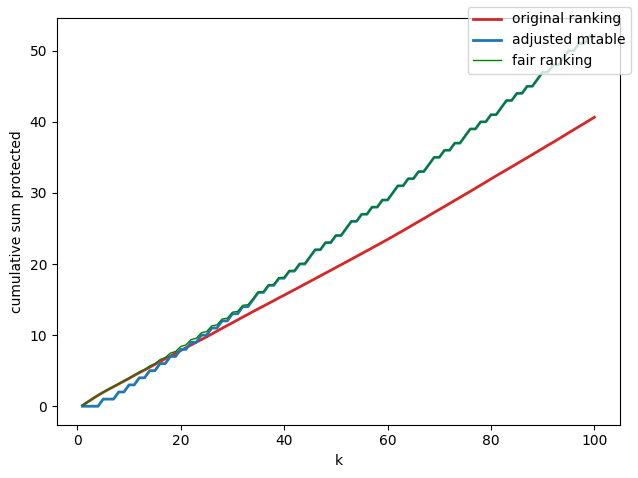

In [63]:
fig, ax1 = plt.subplots()

color = "tab:red"
ax1.set_xlabel("k")
ax1.set_ylabel("cumulative sum protected")
# ax1.plot(range(k), (1-df_for_fair[:k]["developed_country"]).cumsum(), color=color, label="original ranking")
ax1.plot(
    before_fair_cumsum.index[:100],
    before_fair_cumsum.values.flatten()[:100],
    color=color,
    label="original ranking",
    linewidth=2,
)
ax1.plot(
    range(1, 101), fair.create_adjusted_mtable(), label="adjusted mtable", linewidth=2
)
ax1.plot(
    after_fair_cumsum.index,
    after_fair_cumsum.values.flatten(),
    color="green",
    label="fair ranking",
    linewidth=1,
)
fig.legend()

fig.tight_layout()
plt.show()

# Changes

In [34]:
def change_count(orginial_rank, fair_rank):
    change_count = 0
    changes_in_pos = []
    for pos in range(len(orginial_rank)):
        if fair_rank[pos] == 1 and sum(orginial_rank[: pos + 1]) != sum(
            fair_rank[: pos + 1]
        ):
            change_count += 1
        changes_in_pos.append(change_count)
    return changes_in_pos

In [35]:
def change_count(orginial_rank, fair_rank):
    return [
        int(
            fair_rank[pos] == 1
            and sum(orginial_rank[: pos + 1]) != sum(fair_rank[: pos + 1])
        )
        for pos in range(len(orginial_rank))
    ]

In [36]:
np.cumsum(change_count([0, 0, 1, 0, 0, 1], [0, 0, 1, 0, 0, 1]))

array([0, 0, 0, 0, 0, 0])

In [37]:
np.cumsum(change_count([0, 0, 1, 0, 0, 1], [0, 1, 0, 0, 0, 1]))

array([0, 1, 1, 1, 1, 1])

In [38]:
np.cumsum(change_count([0, 0, 1, 0, 0, 1], [0, 1, 0, 1, 0, 0]))

array([0, 1, 1, 2, 2, 2])

In [39]:
np.cumsum(change_count([0, 0, 1, 0, 0, 1], [0, 1, 1, 1, 0, 0]))

array([0, 1, 2, 3, 3, 3])

In [40]:
q_change_count = change_count(
    [int(q.is_protected) for q in questions_rankings[70547027][:100]],
    [int(q.is_protected) for q in questions_rankings_fair[70547027]],
)

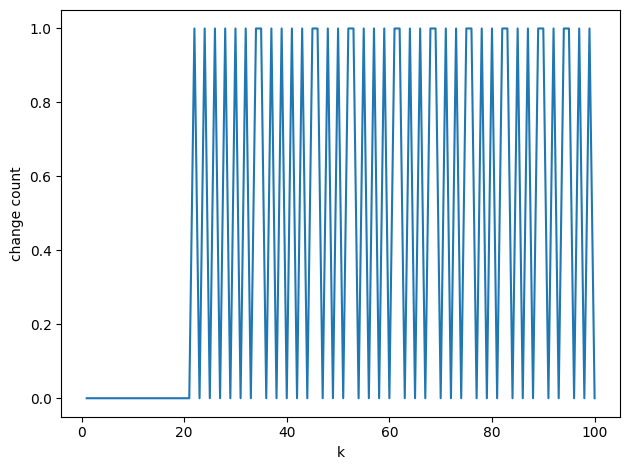

In [41]:
fig, ax1 = plt.subplots()

color = "tab:red"
ax1.set_xlabel("k")
ax1.set_ylabel("change count")
ax1.plot(range(1, 101), q_change_count)

fig.tight_layout()
plt.show()

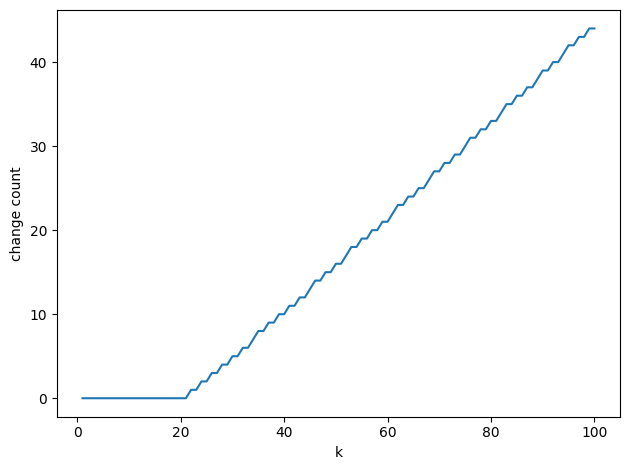

In [42]:
fig, ax1 = plt.subplots()

color = "tab:red"
ax1.set_xlabel("k")
ax1.set_ylabel("change count")
ax1.plot(range(1, 101), np.cumsum(q_change_count))

fig.tight_layout()
plt.show()

In [43]:
all_q_change_counts = []
for q_id, fair_questions in questions_rankings_fair.items():
    all_q_change_counts.append(
        change_count(
            [int(q.is_protected) for q in questions_rankings[q_id][:100]],
            [int(q.is_protected) for q in fair_questions],
        )
    )

all_q_change_counts = np.array(all_q_change_counts)

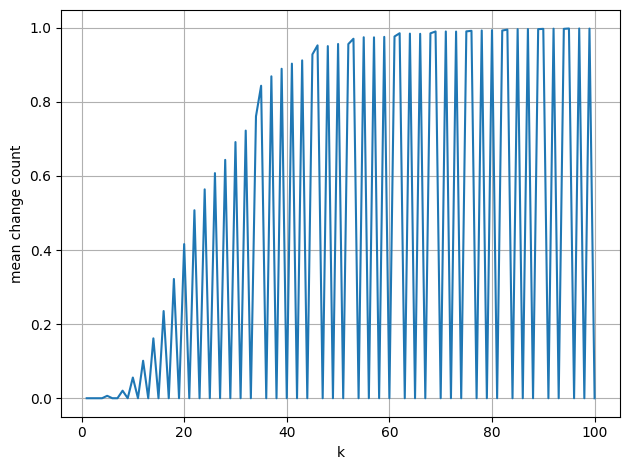

In [44]:
fig, ax1 = plt.subplots()

color = "tab:red"
ax1.set_xlabel("k")
ax1.set_ylabel("mean change count")
ax1.plot(range(1, 101), all_q_change_counts.mean(axis=0))

fig.tight_layout()
plt.grid()
plt.show()

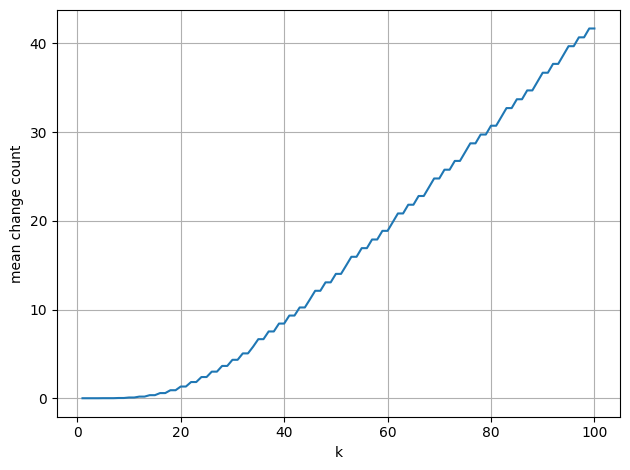

In [45]:
fig, ax1 = plt.subplots()

color = "tab:red"
ax1.set_xlabel("k")
ax1.set_ylabel("mean change count")
ax1.plot(range(1, 101), np.cumsum(all_q_change_counts, axis=1).mean(axis=0))

fig.tight_layout()
plt.grid()
plt.show()

In [46]:
# como la decision de cambiar candidatos es deterministica hay saltos discretos en los ordenamientos

In [47]:
list(enumerate(fair.create_adjusted_mtable(), start=1))[30:50]

[(31, 13),
 (32, 14),
 (33, 14),
 (34, 15),
 (35, 16),
 (36, 16),
 (37, 17),
 (38, 17),
 (39, 18),
 (40, 18),
 (41, 19),
 (42, 19),
 (43, 20),
 (44, 20),
 (45, 21),
 (46, 22),
 (47, 22),
 (48, 23),
 (49, 23),
 (50, 24)]

In [48]:
# con el algo defair estamos generando nuevos sesgos en la genteq consume

In [1]:
# informe:
# la solucion con probas[TTD]


# intente fix proba, pero me fallo pq qda muy a derecha
# p=bla
# me queda a futuro voy a probar con una proba distinta
# p=asd

# agregar en la tesis la parte de fair el entrenamiento /test